In [80]:
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image
import random as rand
import pathlib
from shutil import copyfile
import os
import random
from IPython.display import display
import imageio
from glob import glob
from collections import defaultdict
import math

In [81]:
# os.chdir('/Users/kev/Code/classes/cmsc498m/Project1/notebooks')

In [82]:
TRAINPATH = '../data/processed/illumination/train/'
TESTPATH = '../data/processed/illumination/test/'

In [83]:
class Face():
    def __init__(self, filepath):
        self.vector = self.load_image(filepath)
    
    @property
    def image(self):
        return self.recover_img(self.vector)
        
    def load_image(self, filepath):
        return imageio.imread(filepath).flatten(order='F')  # column-major flatten

    def recover_img(self, v, dim1=40, dim2=48, rotate=270):
        rescaled = v.reshape(dim1, dim2)
        return Image.fromarray(rescaled).rotate(rotate, expand=True)
    
    def __str__(self):
        return "Face<" + str(self.vector) + ">"

class Person():
    """Person (for a series of face photos)."""
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.faces = [Face(file) for file in self.get_image_files(root_dir)]
        
    @property
    def id(self):
        person_str = self.root_dir.split('/')[-2]
        person_no = int(''.join([s for s in person_str if s.isdigit()]))
        return person_no
        
    def get_image_files(self, dir):
        return [filename for filename in glob(dir + os.sep + '*.tif')]
    
    def __str__(self):
        return "Person<" + str(self.id) + ">"
    
class FaceDataset():
    """Illumination Dataset."""
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.persons = [Person(dir) for dir in glob(root_dir + '*/')]
        
    @property
    def images(self):
        return glob(self.root_dir + '/*/*.png')
        
    @property
    def num_persons(self):
        return len(self.persons)
    
    @property
    def num_images(self):
        return sum([len(person) for person in self.persons])
        

In [84]:
train = FaceDataset(TRAINPATH)
test = FaceDataset(TESTPATH)

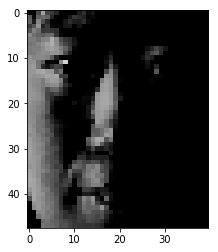

In [85]:
# for person in train.persons:
#     for face in person.faces:
#         print(person)
#         print(face)
        
img = train.persons[0].faces[0].image
plt.imshow(img)

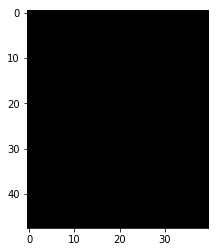

In [86]:
avg = [0]
for person in train.persons:
    for face in person.faces:
        avg += face.vector
    
img = Face.recover_img(None, avg)
plt.imshow(img)

# PCA

In [87]:
%%time
v = np.asarray(train.persons[0].faces[0].vector)[np.newaxis].T
for person in train.persons:
    for face in person.faces:
        new_v = face.vector[np.newaxis].T
        v = np.append(v, new_v, axis=1)

cov = np.cov(v)
display(cov)

array([[2165.69141533, 2141.80608953, 2095.99820338, ..., -738.94506992,
        -680.81930245, -663.77310097],
       [2141.80608953, 2194.69672409, 2175.66858839, ..., -792.23865706,
        -737.43719507, -717.32655034],
       [2095.99820338, 2175.66858839, 2208.30374742, ..., -837.81277658,
        -785.5107728 , -763.93534827],
       ...,
       [-738.94506992, -792.23865706, -837.81277658, ..., 2629.98236325,
        2704.68950545, 2666.01387191],
       [-680.81930245, -737.43719507, -785.5107728 , ..., 2704.68950545,
        2876.43108204, 2857.89556077],
       [-663.77310097, -717.32655034, -763.93534827, ..., 2666.01387191,
        2857.89556077, 2942.70863205]])

CPU times: user 1.38 s, sys: 2.13 s, total: 3.52 s
Wall time: 3.3 s


In [214]:
eigvals, eigvecs = sp.linalg.eigh(cov)

In [220]:
%%time
# Sort by top eigenvalues
idx = eigvals.argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

max([max(v) for v in eigvecs[1:100]])

CPU times: user 25.4 ms, sys: 8.03 ms, total: 33.4 ms
Wall time: 32.5 ms


Text(0.5,0.98,'Top 100 Eigenfaces')

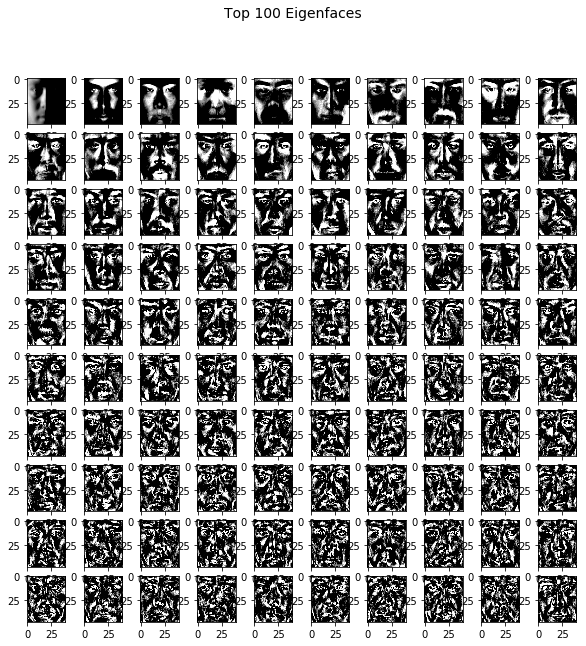

In [90]:
scale=1
fig=plt.figure(figsize=(10*scale, 10*scale))
columns = 10
rows = 10
for i in range(1, 101):
    img = Face.recover_img(None, eigvecs[:,i]*1e4)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
fig.suptitle('Top 100 Eigenfaces', fontsize=14)

# LDA

In [ ]:
mean_vectors = []

# KNN

In [91]:
from sklearn.neighbors import KNeighborsClassifier

In [291]:
# Get image vectors and class labels of training set
train_X = []
train_Y = []
for person in train.persons:
    for face in person.faces:
        train_X.append(face.vector)
        train_Y.append(person.id)

In [292]:
# Get image vectors and class labels of test set
test_X = []
test_Y = []
for person in test.persons:
    for face in person.faces:
        test_X.append(face.vector)
        test_Y.append(person.id)

In [141]:
def euclideanDistance(v1, v2):
    if (len(v1) != len(v2)):
        raise Exception("Vectors not equal")
    distance = 0
    for x in range(min(len(v1),len(v2))):
        distance += math.pow((v1[x] - v2[x]), 2)
    return math.sqrt(distance)

In [144]:
from queue import PriorityQueue

def getNeighbors(train_set, train_labels, test, k):
    distances = PriorityQueue()
    for i in range(len(train_set)):
       distances.put((euclideanDistance(test, train_set[i]), train_labels[i]))
    neighbors = []
    for _ in range(k):
        neighbors.append(distances.get())
    return neighbors

In [173]:
def getMajorityVote(neighbors):
    votes = defaultdict(int)
    for i in range(len(neighbors)):
        label = neighbors[i][-1]
        votes[label] += 1
    return sorted(votes.items(), key=lambda k_v: k_v[1])[-1][0]

In [196]:
class KNNClassifier():
    def __init__(self, neighbors=1):
        self.neighbors = neighbors
        self.train_set = None
        self.train_labels = None
        
    def fit(self, train_set, train_labels):
        self.train_set = train_set
        self.train_labels = train_labels
        
    def predict(self, test_image):
        if self.train_set is None or self.train_labels is None:
            raise Exception
            
        neighbors = getNeighbors(self.train_set, self.train_labels, test_image, self.neighbors)
        response = getMajorityVote(neighbors)
        return response
    
    def score(self, test_set, test_labels):
        correct = 0.
        for i in range(len(test_set)):
            if self.predict(test_set[i]) == test_labels[i]:
                correct += 1.
        return correct / len(test_set)

In [307]:
%%timeit
model = KNNClassifier(neighbors=1)
model.fit(train_X, train_Y)
model.predict(test_X[99])

1.08 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [218]:
%%time
model = KNNClassifier(neighbors=1)
model.fit(train_X, train_Y)
acc = model.score(test_X, test_Y)

CPU times: user 6min 9s, sys: 938 ms, total: 6min 10s
Wall time: 6min 11s


In [221]:
acc

0.9264705882352942

## PCA then KNN

In [363]:
eigvecs_f50 = eigvecs[:,:10]  # get first 50 eigvecs
eigvecs_f50

array([[-0.00226145, -0.025027  , -0.01146537, ...,  0.022937  ,
         0.00734408,  0.02484251],
       [-0.00239018, -0.02588956, -0.01295579, ...,  0.02065672,
         0.00909039,  0.02138532],
       [-0.0027461 , -0.0263715 , -0.01541141, ...,  0.0187638 ,
         0.01273359,  0.01972373],
       ...,
       [ 0.01149311,  0.01415494, -0.01650294, ..., -0.12551223,
         0.01735871, -0.00245298],
       [ 0.01228028,  0.01352862, -0.01876114, ..., -0.13090341,
         0.01868523, -0.00314239],
       [ 0.01295127,  0.01349942, -0.01816111, ..., -0.12250026,
         0.01749192, -0.00447728]])

In [364]:
eigvecs_f50_m3 = eigvecs_f50[:,3:]  # delete first three eigvecs
eigvecs_f50_m3

array([[-0.04086506,  0.02667724,  0.02105273, ...,  0.022937  ,
         0.00734408,  0.02484251],
       [-0.04084046,  0.0291704 ,  0.02539454, ...,  0.02065672,
         0.00909039,  0.02138532],
       [-0.03868613,  0.03077655,  0.02412022, ...,  0.0187638 ,
         0.01273359,  0.01972373],
       ...,
       [-0.02855812, -0.0277798 , -0.0533065 , ..., -0.12551223,
         0.01735871, -0.00245298],
       [-0.02931238, -0.02367291, -0.05445615, ..., -0.13090341,
         0.01868523, -0.00314239],
       [-0.02958827, -0.02248274, -0.05247219, ..., -0.12250026,
         0.01749192, -0.00447728]])

In [318]:
# Project Train and Test onto Eigenvector Matrix
def project_eigenface(M, vectors):
    return [M @ v for v in vectors]

pr_train_X = project_eigenface(eigvecs_f50_m3.T, train_X)
pr_test_X = project_eigenface(eigvecs_f50_m3.T, test_X)

In [319]:
%%timeit
model = KNNClassifier(neighbors=10)
model.fit(pr_train_X, train_Y)
model.predict(pr_test_X[10])

8.91 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [365]:
%%timeit
model = KNNClassifier(neighbors=1)
model.fit(pr_train_X, train_Y)
acc = model.score(pr_test_X, test_Y)

11.3 s ± 70.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [321]:
acc

0.8264705882352941

In [342]:
%%time
accs = []
for i in range(1,6):
    eigvecs_f = eigvecs[:,:i*10]
    pr_train_X = project_eigenface(eigvecs_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs.append(acc)

CPU times: user 36.7 s, sys: 78.2 ms, total: 36.8 s
Wall time: 36.8 s


Text(0.5,1,'1-Neighbor Top Eigenface Image Classification')

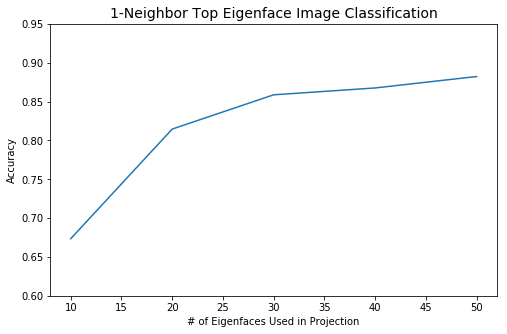

In [359]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(10,60,10), accs)
plt.ylabel('Accuracy')
plt.xlabel('# of Eigenfaces Used in Projection')
plt.yticks(np.arange(0.6,1,0.05))
plt.title('1-Neighbor Top Eigenface Image Classification', fontsize=14)

In [361]:
# Accuracy of 30 eigenfaces
accs[2]

0.8588235294117647

In [366]:
%%time
accs = []
for i in range(6):
    eigvecs_f = eigvecs[:,i:30]
    pr_train_X = project_eigenface(eigvecs_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs.append(acc)

CPU times: user 41 s, sys: 147 ms, total: 41.1 s
Wall time: 41.3 s


Text(0.5,1,'1-Neighbor 30 Eigenface Image Classification')

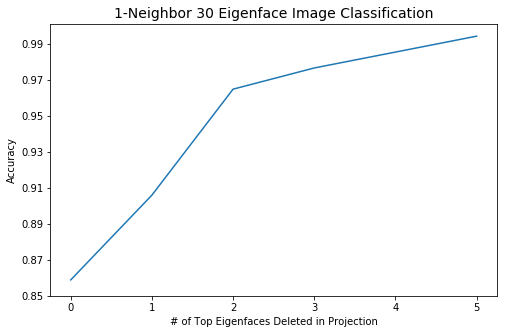

In [372]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(6), accs)
plt.ylabel('Accuracy')
plt.xlabel('# of Top Eigenfaces Deleted in Projection')
plt.yticks(np.arange(0.85,1,0.02))
plt.title('1-Neighbor 30 Eigenface Image Classification', fontsize=14)

In [373]:
# top 30 - 5
eigvecs_f = eigvecs[:,5:30]
pr_train_X = project_eigenface(eigvecs_f.T, train_X)
pr_test_X = project_eigenface(eigvecs_f.T, test_X)
model = KNNClassifier(neighbors=1)
model.fit(pr_train_X, train_Y)
acc = model.score(pr_test_X, test_Y)

In [374]:
acc

0.9941176470588236

In [381]:
%%time
accs1 = []
for i in range(24):
    eigvecs_f = eigvecs[:,i+6:30]
    pr_train_X = project_eigenface(eigvecs_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs1.append(acc)

CPU times: user 1min 38s, sys: 854 ms, total: 1min 39s
Wall time: 1min 40s


Text(0.5,1,'1-Neighbor 30 Eigenface Image Classification')

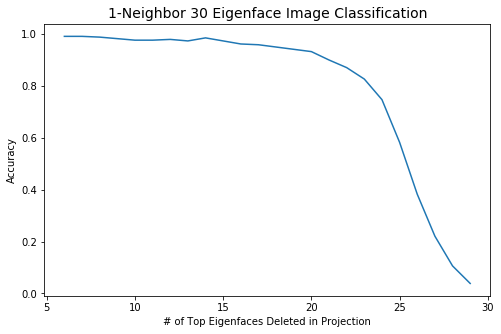

In [386]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(6,30), accs1)
plt.ylabel('Accuracy')
plt.xlabel('# of Top Eigenfaces Deleted in Projection')
plt.title('1-Neighbor 30 Eigenface Image Classification', fontsize=14)

In [395]:
%%time
# top 30 - top 15
eigvecs_f = eigvecs[:,5:30]

accs2 = []
for i in range(1,6):
    pr_train_X = project_eigenface(eigvecs_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f.T, test_X)
    model = KNNClassifier(neighbors=i)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs2.append(acc)

CPU times: user 32.2 s, sys: 111 ms, total: 32.3 s
Wall time: 32.3 s


Text(0.5,1,'K-Neighbor 30 (-5) Eigenface Image Classification')

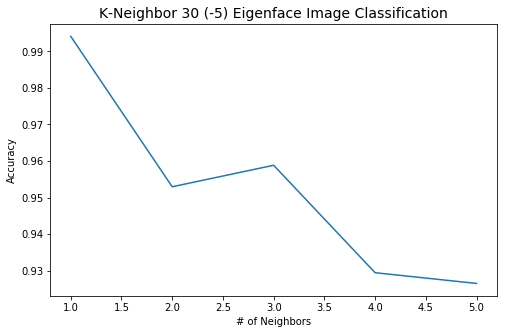

In [399]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(1,6),accs2)
plt.ylabel('Accuracy')
plt.xlabel('# of Neighbors')
plt.title('K-Neighbor 30 (-5) Eigenface Image Classification', fontsize=14)

In [400]:
accs2

[0.9941176470588236,
 0.9529411764705882,
 0.9588235294117647,
 0.9294117647058824,
 0.9264705882352942]